# Click-Through Rate Prediction with Stochastic Gradient Descent

In Internet marketing, [click-through rate (CTR)](https://en.wikipedia.org/wiki/Click-through_rate#:~:text=Click%2Dthrough%20rate%20(CTR)) is a metric that measures the number of clicks advertisers receive on their ads per number of impressions.

The goal of this project is to predict whether mobile advertisements from [CriteoLabs](https://labs.criteo.com/), a multinational digital marketing company, will be clicked. I'll use stochastic gradient descent algorithm called Pegasos, an algorithm commonly used for   predictions. 

> Click-through rate (CTR) is the ratio of users who click on a specific link to the number of total users who view a page, email, or advertisement. It is commonly used to measure the success of an online advertising campaign for a particular website as well as the effectiveness of email campaigns.  

CTR prediction systems are essential to informing decisions related to sponsored search and real-time bidding.

## Contents: ##
### 1. [Dataset Description](#s1)  
- 1.1 [Descriptive Statistics](#s1.1)
- 1.2 [Data Cleaning & Feature Selection](#s1.2)
- 1.3 [Data Visualizations](#s1.3)

### 2. [Feature Engineering](#s2)  
- 2.1 [Normalization](#s2.1)  
- 2.2 [Standardization](#s2.2) 
- 2.3 [One-hot Encoding](#s2.3)  


### 3. [Predictive Modeling](#s3)
- 3.1 [A Generic Classifier Object](#s3.1)
- 3.2 [Decision Boundary Plot Function](#s3.2)
- 3.3 [Regularized Logistic Regression Classifier](#s3.3)
- 3.4 [Regularized Hinge Loss Support Vector Machine Classifier](#s3.4)
- 3.5 [Implementing the Pegasos Algorithm](#s3.5)
- 3.6 [Pegasos on Criteo CTR Prediction Data](#s3.6)

[TODO](#sTODO)

----
<a id='s1'></a>
# 1. Dataset Description 
### Data Source:###
The data is sourced from [CriteoLabs](https://labs.criteo.com/), a multinational corporation in the digital marketing industry that specializes in algorithmic approaches to determine what to show users. 

In an [old kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge), 7 days worth of Criteo's ad data was released. From here on out, this will be referred to as "the Criteo data" in the notebook. The Criteo data is contained in the 'CTR_data.csv' file. 

### Data Fields

- Label - Target variable that indicates if an ad was clicked (1) or not (0).
- I1-I13 - A total of 13 columns of integer features (mostly count features).
- C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes.  

The semantics of the features remain undisclosed.  
  When a value is missing, the field is empty.

<a id='s1.1'></a>
## 1.1 Descriptive Statistics

In [1]:
# Necessary imports from data science stack
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns; sns.set()

from sklearn.preprocessing import OneHotEncoder # for preprocessing
from scipy.optimize import minimize
from numpy.lib import recfunctions as rfn

# built-in modules used
import math
import pprint

# my custom classes
import helper_functions

In [2]:
# Load in the training data.
data = np.genfromtxt('CTR_data.csv', dtype=float, delimiter=',', names=True)
data = pd.DataFrame(data)

In [3]:
data

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,4.439394e+18,0.0,14102923.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,15706.0,320.0,50.0,1722.0,0.0,35.0,-1.0,79.0
1,1.448977e+19,0.0,14102518.0,1005.0,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,20632.0,320.0,50.0,2374.0,3.0,39.0,100148.0,23.0
2,5.188284e+18,0.0,14102109.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,21760.0,320.0,50.0,2502.0,0.0,35.0,-1.0,221.0
3,1.070857e+19,0.0,14102406.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,456.0,320.0,50.0,122.0,3.0,1327.0,100013.0,15.0
4,4.824233e+18,0.0,14102507.0,1010.0,1.0,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,17877.0,320.0,50.0,2036.0,3.0,47.0,-1.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9.368645e+18,0.0,14102619.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,21191.0,320.0,50.0,2424.0,1.0,161.0,100193.0,71.0
19996,1.237151e+19,0.0,14102109.0,1005.0,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,19950.0,320.0,50.0,1800.0,3.0,167.0,100074.0,23.0
19997,8.159734e+17,0.0,14102811.0,1002.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6366.0,300.0,50.0,544.0,3.0,39.0,100079.0,23.0
19998,4.530238e+18,1.0,14102214.0,1005.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,18094.0,320.0,50.0,2060.0,3.0,39.0,100241.0,23.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  float64
 1   click             20000 non-null  float64
 2   hour              20000 non-null  float64
 3   C1                20000 non-null  float64
 4   banner_pos        20000 non-null  float64
 5   site_id           83 non-null     float64
 6   site_domain       1780 non-null   float64
 7   site_category     1553 non-null   float64
 8   app_id            194 non-null    float64
 9   app_domain        401 non-null    float64
 10  app_category      0 non-null      float64
 11  device_id         132 non-null    float64
 12  device_ip         673 non-null    float64
 13  device_model      441 non-null    float64
 14  device_type       20000 non-null  float64
 15  device_conn_type  20000 non-null  float64
 16  C14               20000 non-null  float6

<a id='s1.2'></a>
## 1.2. Data Cleaning & Feature Selection

Running the `pd.DataFrame.info` method showed me that there was too much missing data from a few of the features, so I'll go ahead and remove them.

In [5]:
# Remove uninformative columns from the dataset.
useless = ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain',
          'app_category', 'device_id', 'device_ip', 'device_model']
data = data.drop(useless,axis=1) 
print(data.columns)

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21'],
      dtype='object')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  float64
 1   click             20000 non-null  float64
 2   hour              20000 non-null  float64
 3   C1                20000 non-null  float64
 4   banner_pos        20000 non-null  float64
 5   device_type       20000 non-null  float64
 6   device_conn_type  20000 non-null  float64
 7   C14               20000 non-null  float64
 8   C15               20000 non-null  float64
 9   C16               20000 non-null  float64
 10  C17               20000 non-null  float64
 11  C18               20000 non-null  float64
 12  C19               20000 non-null  float64
 13  C20               20000 non-null  float64
 14  C21               20000 non-null  float64
dtypes: float64(15)
memory usage: 2.3 MB


Now, I'd like to investigate further whether some of my features have relevant information for CTR predictions. If I feed in irrelevant features to the model, it can have negative effects on performance. 

In [7]:
data.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,2.000000e+04,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.000000,20000.000000,20000.00000
mean,9.212012e+18,0.167700,1.410256e+07,1004.968100,0.288500,1.015550,0.336100,18823.226900,318.839200,59.84060,2109.93395,1.422950,227.952450,53053.925150,83.27900
std,5.302847e+18,0.373609,2.953851e+02,1.093226,0.506044,0.525378,0.859287,4985.643995,19.937593,47.08106,612.51091,1.321912,352.471207,49967.918971,69.86019
min,7.801431e+13,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,216.000000,36.00000,112.00000,0.000000,33.000000,-1.000000,13.00000
25%,4.618343e+18,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.00000,1806.75000,0.000000,35.000000,-1.000000,23.00000
50%,9.225258e+18,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.00000,2323.00000,2.000000,39.000000,100048.000000,61.00000
75%,1.378395e+19,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21893.000000,320.000000,50.00000,2526.00000,3.000000,171.000000,100084.000000,100.00000
max,1.844638e+19,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24041.000000,768.000000,1024.00000,2756.00000,3.000000,1839.000000,100248.000000,255.00000


In [8]:
# Display a table containing information on the unique values in each column.
data.agg(['nunique', 'count', 'size'])

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
nunique,20000,2,240,7,6,4,4,1202,6,7,351,4,61,136,58
count,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
size,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000


From the above aggregate table, it appears that 'id' may be a numerical feature. I want to check its correlation with other variables to see if this column has any predictive power. I'll also do this for the other numerical feature, 'hour'.

In [9]:
data.corr().round(2).loc['id']

id                  1.00
click              -0.01
hour                0.01
C1                 -0.00
banner_pos         -0.01
device_type        -0.00
device_conn_type   -0.00
C14                 0.01
C15                -0.00
C16                -0.00
C17                 0.01
C18                -0.01
C19                -0.00
C20                -0.01
C21                 0.01
Name: id, dtype: float64

In [10]:
data.corr().round(2).loc['hour']

id                  0.01
click               0.00
hour                1.00
C1                  0.00
banner_pos          0.04
device_type         0.00
device_conn_type    0.05
C14                 0.19
C15                 0.02
C16                -0.00
C17                 0.18
C18                 0.01
C19                 0.05
C20                 0.02
C21                 0.06
Name: hour, dtype: float64

'id' doesn't correlate with anything else, so I'm okay with throwing it out.

In [11]:
# Remove 'id' feature from the dataset
data = data.drop(['id'],axis=1) 

Recall the description of the data fields from the beginning of the notebook:
>  
- Label : 'click' - Target variable that indicates if an ad was clicked (1) or not (0).
- I1-I13 - A total of 13 columns of integer features (mostly count features).
- C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes.     
The semantics of the features remain undisclosed.

With this description in mind and the aggregate table above, it appears that **all of the features are categorical** except 'hour', which I'm unsure about. On one hand, there are a small enough number of unique values in 'hour' that I can treat it as if it *is* categorical, however it's probably more telling to see if the time of day will end up being a useful predictor. My hunch is that it will.

<a id='s1.3'></a>
## 1.3 Data Visualizations

0.0    16646
1.0     3354
Name: click, dtype: int64

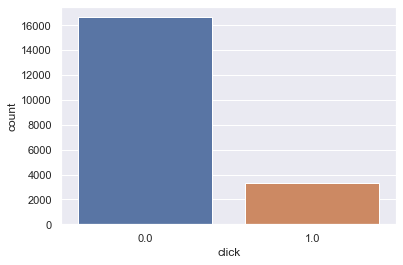

In [12]:
# Display the distribution of clicks and non-clicks (our target variable)
sns.countplot(data = data, x = 'click')
data['click'].value_counts()

<AxesSubplot:>

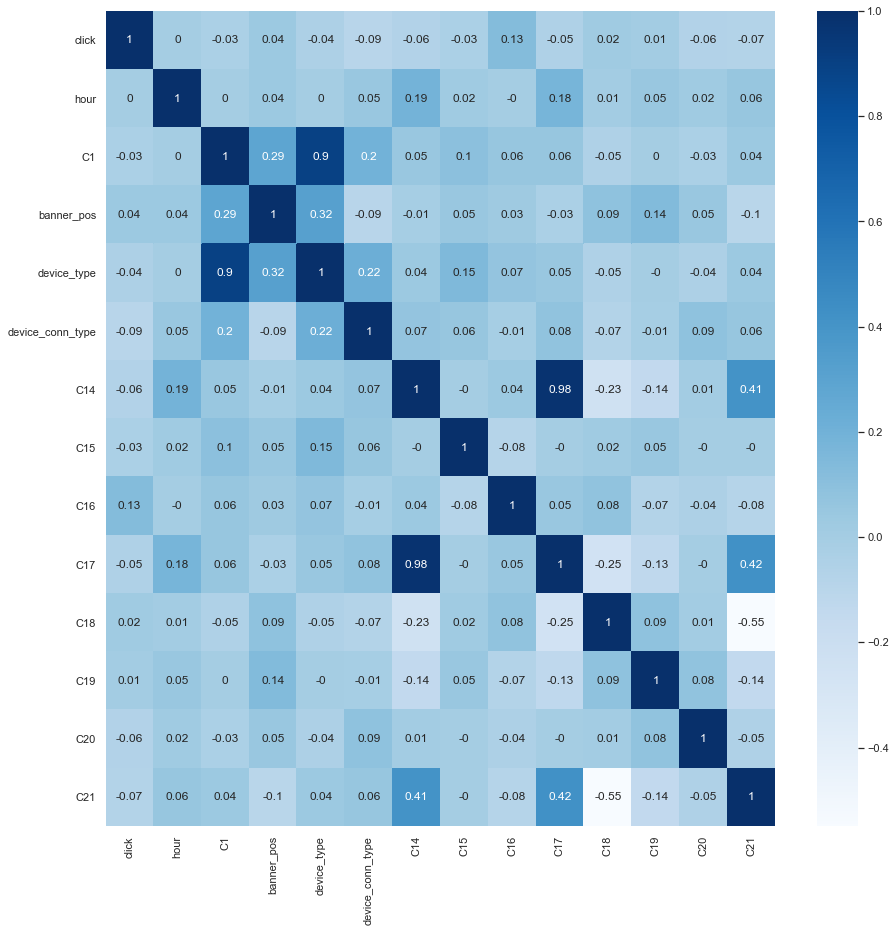

In [13]:
# Display correlation matrix
corr = data.corr().round(2)
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='Blues')

The `pd.DataFrame.corr()` method only implements correlation coefficients (Pearson, Kendall, Spearman) for numerical variables. Because many of the categorical features happen to be represented by numbers, much of this plot is somewhat nonsensical. 

I'll instead use chi-squared to try to understand more about the relationship between the categorical features.
> The $\chi^2$ test is used to determine whether an association (or relationship) between two categorical variables in a sample is likely to reflect a real association between these variables in the population.

From [Jason Brownlee](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/),
> In the case of classification problems where input variables are also categorical, we can use statistical tests to determine whether the output variable is dependent or independent of the input variables. If independent, then the input variable is a candidate for a feature that may be irrelevant to the problem and removed from the dataset.  

> The [Pearson’s chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test) gives us an idea of the independence between categorical variables. The test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories.

In [14]:
dt = helper_functions.data_transform(data)
dt.target_names = ['click']
dt.feat_names = dt.get_feature_names()
dt.num_features = ['hour']
dt.cat_features = dt.get_cat_features()

In [15]:
cat_features = dt.get_cat_features()
feature_names = dt.get_feature_names()
target_names = dt.get_target_names()

X = data[feature_names]
Y = data[target_names]

In [16]:
# TODO : Chi-square test on categorical features
from sklearn.feature_selection import chi2 as sklearn_chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X_cat = data[dt.cat_features]
X_cat.head()

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1005.0,0.0,1.0,0.0,15706.0,320.0,50.0,1722.0,0.0,35.0,-1.0,79.0
1,1005.0,1.0,1.0,0.0,20632.0,320.0,50.0,2374.0,3.0,39.0,100148.0,23.0
2,1005.0,0.0,1.0,0.0,21760.0,320.0,50.0,2502.0,0.0,35.0,-1.0,221.0
3,1005.0,0.0,1.0,0.0,456.0,320.0,50.0,122.0,3.0,1327.0,100013.0,15.0
4,1010.0,1.0,4.0,2.0,17877.0,320.0,50.0,2036.0,3.0,47.0,-1.0,156.0


In [17]:
X_cat = pd.DataFrame(enc.fit_transform(X_cat),index=X_cat.index,
        columns=X_cat.columns)

In [18]:
chi2_stat, p = sklearn_chi2(X_cat, Y) # chi2 statistic and pval for each feature
chi2_matrix = pd.DataFrame(chi2_stat.reshape(1,12), 
        index=['Chi-squared statistic'], columns=X_cat.columns).round(decimals=2)
p_matrix = pd.DataFrame(p.reshape(1,12),
        index=['p-value'], columns = X_cat.columns).round(decimals=2)

pd.concat([chi2_matrix, p_matrix], axis=0)

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
Chi-squared statistic,2.61,18.87,3.03,218.65,15792.29,9.03,69.81,3336.38,12.68,1.04,4838.85,1801.4
p-value,0.11,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.0


In [19]:
np.set_printoptions(suppress=True) # surpresses the use of scientific notation
kbest = SelectKBest(score_func=sklearn_chi2, k=1)
bestfit = kbest.fit(X_cat, Y)
X_r = bestfit.transform(X_cat)

bestfeatures = []
for i in range(X_r.shape[1]):
    for j in range(X_cat.shape[1]):
        comparison = np.array(X_cat.iloc[:,j]) == X_r[:,i]
        if comparison.all():
            bestfeatures.append(X_cat.iloc[:,j].name)
len(bestfeatures), X_cat.shape[1], bestfeatures

(1, 12, ['C14'])

In [20]:
np.array(X_cat.iloc[:,0]) == X_r[:,0]

array([False, False, False, ..., False, False, False])

In [21]:
X_cat.values

array([[  2.,   0.,   1., ...,   2.,   0.,  21.],
       [  2.,   1.,   1., ...,   4.,  87.,   5.],
       [  2.,   0.,   1., ...,   2.,   0.,  52.],
       ...,
       [  1.,   0.,   0., ...,   4.,  50.,   5.],
       [  2.,   0.,   1., ...,   4., 134.,   5.],
       [  2.,   0.,   1., ...,   2.,   0.,  21.]])

----
<a id='s2'></a>
# 2. Feature Engineering

This section involves loading a sample of the Criteo data and preprocessing categorical features with one-hot-encoding. 

<a id='s2,1'></a>
### 2.1 Normalization

In [22]:
# Normalize the numerical features, i.e. the 'hour' column.
from sklearn.preprocessing import MinMaxScaler

def normalize(vector):
    min_max_scaler = MinMaxScaler()
    scaled_vector = min_max_scaler.fit_transform(vector)
    return scaled_vector

for i in dt.num_features: # Loop through the numerical features.
    data[i] = normalize(data[[i]])

In [23]:
data[dt.num_features].describe()

,hour
count,20000.000000
mean,0.493135
std,0.320027
min,0.000000
25%,0.221018
50%,0.542795
75%,0.772481
max,1.000000


<a id='s2.2'></a>
### 2.2 Standardization

In [24]:
data[dt.num_features].skew()

hour    0.001952
dtype: float64

In [25]:
# Standardize the numerical features, i.e. the 'hour' column.
from sklearn.preprocessing import StandardScaler

def standardize(vector):
    scaler = StandardScaler()
    scaled_vector = scaler.fit_transform(vector)
    return scaled_vector

for i in dt.num_features: # Loop through the numerical features.
    data[i] = standardize(data[[i]])

In [26]:
X = data[feature_names]
Y = data[target_names]

X

,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.245308,1005.0,0.0,1.0,0.0,15706.0,320.0,50.0,1722.0,0.0,35.0,-1.0,79.0
1,-0.125818,1005.0,1.0,1.0,0.0,20632.0,320.0,50.0,2374.0,3.0,39.0,100148.0,23.0
2,-1.510486,1005.0,0.0,1.0,0.0,21760.0,320.0,50.0,2502.0,0.0,35.0,-1.0,221.0
3,-0.504993,1005.0,0.0,1.0,0.0,456.0,320.0,50.0,122.0,3.0,1327.0,100013.0,15.0
4,-0.163058,1010.0,1.0,4.0,2.0,17877.0,320.0,50.0,2036.0,3.0,47.0,-1.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.216117,1005.0,0.0,1.0,3.0,21191.0,320.0,50.0,2424.0,1.0,161.0,100193.0,71.0
19996,-1.510486,1005.0,1.0,1.0,0.0,19950.0,320.0,50.0,1800.0,3.0,167.0,100074.0,23.0
19997,0.866132,1002.0,0.0,0.0,0.0,6366.0,300.0,50.0,544.0,3.0,39.0,100079.0,23.0
19998,-1.155009,1005.0,0.0,1.0,0.0,18094.0,320.0,50.0,2060.0,3.0,39.0,100241.0,23.0


Currently the labels, $y\in Y$, in the Criteo data are such that $y\in \{0, 1\}$. For the ML model I'm using, I need to convert the 0's to -1's instead.

In [27]:
Y['click'].value_counts()

0.0    16646
1.0     3354
Name: click, dtype: int64

In [28]:
Y.loc[Y.click == 0, 'click'] = -1
Y['click'].value_counts()

C:\Users\uniqu\anaconda3\envs\ds_env\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-28-4609c570f338>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y.loc[Y.click == 0, 'click'] = -1


-1.0    16646
 1.0     3354
Name: click, dtype: int64

<a id='s2.3'></a>
### 2.3 One-Hot Encoding

**One-hot encoding** is a method for turning categorical variables into continuous variables when no ordinal relationship exists. Most ML algorithms require numerical input, similar to the ones in this notebook.

In [29]:
X = dt.one_hot_encode()
X

,click,hour,C1_1001.0,C1_1002.0,C1_1005.0,C1_1007.0,C1_1008.0,C1_1010.0,C1_1012.0,banner_pos_0.0,...,C21_195.0,C21_204.0,C21_212.0,C21_219.0,C21_221.0,C21_229.0,C21_246.0,C21_251.0,C21_253.0,C21_255.0
0,0.0,1.245308,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.0,-0.125818,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,-1.510486,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0.0,-0.504993,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,-0.163058,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.216117,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19996,0.0,-1.510486,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,0.0,0.866132,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19998,1.0,-1.155009,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


I'll also load a small dataset that is easily separable for use in logistic regression for sanity checks. It's in the 'logistic_regression.csv' file. I'm using this file to perform tests on my models before running everything on the Criteo data, since that dataset is somewhat large.

----
<a id='s3'></a>
# 3. Predictive Modeling

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=7)

In [30]:
# Sanity check: Load the small dataset.
small_data = np.genfromtxt('logistic_regression.csv', dtype=float,
        delimiter=',', names=True)
small_data = rfn.structured_to_unstructured(small_data)
print('Loaded a small dataset for sanity check: ', small_data.shape)
small_data_X = small_data[:, 0:2]
small_data_Y = small_data[:, 2]

Loaded a small dataset for sanity check:  (200, 3)


----
<a id='s3'></a>
# 3. A Generic Classifier Object
Here is a generic classifier class with some useful functions. As we define more classifiers, we will inherit from this base class and implement supplementary methods.

In [31]:
# A class for generic classifiers.
class classifier:
    """A generic classifier object. The `weight` attribute is updated after each
    gradient step.

    """
    # Takes the number of features as an input and initializes the classifier.
    def __init__(self, n_features):
        
        # Each classifier stores a weight vector whose size is equal to the number of features.
        self.weight_ = np.zeros( (n_features,) )

    def set_mini_batch_size(self, mini_batch_size_in):
        """Sets the mini batch size used for the classifier.

        Args:
            mini_batch_size_in (int): [description]
        """
        self.mini_batch_size_ = mini_batch_size_in
    
    # 
    def init_history(self, n_epochs):
        """Initializes the history vectors.

        Args:
            n_epochs (int): the number of iterations or passes of the 
                training set the algorithm completes; equivalently, the number 
                of times the weight vectors have been updated
        """
        self.obj_val_history_ = np.zeros( (n_epochs + 1, ))
        self.l2_norm_gradient_history_ = np.zeros(( n_epochs + 1, ))
        self.training_unregularized_loss_history_ = np.zeros( (n_epochs + 1, ) )
        self.validation_unregularized_loss_history_ = np.zeros( (n_epochs + 1, ) )
    
    def batch_classify(self, x_mat):
        """[summary]

        Args:
            x_mat (array, 2D):  A matrix in which each row is a point

        Returns:
            (array, 1D): Binary classification results. An array consisting of 
                values in set {-1,1}
        """
        return np.array([ self.classify(x_vec) for x_vec in x_mat])
       
    def update_weight(self, learning_rate, weight_gradient):
        """Performs one update to the weight vector.

        Args:
            learning_rate (float): [description]
            weight_gradient ([type]): [description]
        """
        self.weight_ = self.weight_ - learning_rate * weight_gradient
    
    # Stores history of optimization progress.
    def add_to_history(self, obj_val, weight_gradient, epoch_num, X, Y,
            validation_data_X, validation_data_Y ):
        """[summary]

        Args:
            obj_val ([type]): [description]
            weight_gradient ([type]): [description]
            epoch_num ([type]): [description]
            X ([type]): [description]
            Y ([type]): [description]
            validation_data_X ([type]): [description]
            validation_data_Y ([type]): [description]
        """
        self.obj_val_history_[epoch_num] = obj_val
        self.l2_norm_gradient_history_[epoch_num] = np.linalg.norm(weight_gradient, 2)
        self.training_unregularized_loss_history_[epoch_num] = self.compute_unregularized_loss(X, Y)

        if validation_data_X is not None:
            self.validation_unregularized_loss_history_[epoch_num] = \
                self.compute_unregularized_loss(validation_data_X, validation_data_Y)

----
<a id='s3.1'></a>
# 3.1 Decision Boundary Plot Function

In [32]:
def plot_data(classifier, X, Y):
    """plots the decision boundary for a binary classifier

    Args:
        classifier ([type]): [description]
        X ([type]): [description]
        Y ([type]): [description]
    """
    weight = classifier.weight_
    y_pred = [classifier.classify(x) for x in X]
    tp = (Y == y_pred)  # true positives, i.e. correctly classified
    tp0, tp1 = tp[Y == -1], tp[Y == 1]
    X0, X1 = X[Y == -1], X[Y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]
    
    plt.figure(figsize=(12,9))
    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 200
    x_min, x_max = (-20, 20)
    y_min, y_max = (-20, 20)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, nx),
        np.linspace(y_min, y_max, ny))
    
    xgrid = np.arange(-20, 20, 0.1)
    ygrid = [ - weight[0] / weight[1] * x_val for x_val in xgrid ]
    plt.plot(xgrid, ygrid, '--')

    # Show plots.
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

----- 
<a id='s3.2'></a>
# 3.2 Regularized Logistic Regression Classifier
In this section, the `classifier` class is extended to implement the `logistic_regression_classifier` class. 

The regularized logistic regression is the solution to the following optimization problem,
$$\arg\min\limits_{\mathbf{w}} \frac{\lambda \mathbf{w}^T \mathbf{w} }{2} + \frac{1}{N} \sum\limits_{i = 1}^N 
\ell_{\mathsf{logistic}}(y^{(i)}, \mathbf{w}^T \mathbf{x}^{(i)})$$
where the **logistic loss** is defined by:
$$\begin{align*}
\ell_{\mathsf{logistic}}(y, \mathbf{w}^T \mathbf{x}) = \ln \left ( 1 + \exp(- y \cdot \mathbf{w}^T \mathbf{x} ) \right )
\end{align*}$$
for some regularization parameter $\lambda > 0$.

In the class below, I implement the `obj_gradient_function`, which computes the regularized objective value and its gradient using a subset of training points whose indices are in the `mini_batch_indices` variable. For the regularized objective value, this function computes a *Monte Carlo approximation* of the regularized objective function at the current parameter, $\mathbf{w}$:
$$\frac{\lambda \mathbf{w}^T \mathbf{w}}{2} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} \ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
and a *Monte Carlo approximation* of the gradient:
$$\lambda \mathbf{w} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} 
\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{logistic}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$

Note that the batch gradient descent is a special case: $M = \{ ( \mathbf{x}^{(i)}, y^{(i)})\}_{i = 1}^N$.

In [33]:
class logistic_regression_classifier(classifier):
    """  
    Methods:
        compute_obj_val: whether the function returns the objective value.
        compute_gradient: whether the function returns the gradient.
    """
    def __init__(self, num_dimensions):
        super(logistic_regression_classifier, self).__init__(num_dimensions)
        
    # define binary classifier function
    def classify(self, x_vec):
        """Classifies a particular data vector as 1 or -1 based on weight."""
        if np.dot(self.weight_, x_vec) > 0:
            return 1
        else:
            return -1

    def compute_unregularized_loss(self, x_mat, y_vec):
        """Compute unregularized loss.
        
        Parameters:
            X (2-D array): A feature matrix
            Y (1-D array): A vector of labels
            
        Returns:
            unregularized_loss
        """
        unregularized_loss = np.mean([ np.log(1 + np.exp(-y_vec[i] * np.dot(self.weight_, x_vec))) for i, x_vec in enumerate(x_mat) ])
        return unregularized_loss
    
    @staticmethod
    def obj_gradient_function(weight, X, Y, mini_batch_indices, 
                              regularization, compute_obj_val=True, 
                              compute_gradient=True):
        """Computes the regularized objective value and its gradient.
        
        Parameters:
            weight: the weight vector
            X: the data matrix
            Y: the y vector
            mini_batch_indices: the subsample rows to choose in the X, Y pair.
            regularization: the regularization parameter, lambda
                
        Returns:
            obj_val OR weight_gradient
            
            obj_val : objective value
            weight_gradient :
                
        """        
        
        # Set initial values for obj_val and weight_gradient to 0
        obj_val = 0.0
        weight_gradient = np.zeros((X.shape[1],))

        for i, (x_vec, y_label) in enumerate(
            zip(X[mini_batch_indices, :], Y[mini_batch_indices])):
            
            obj_val+= np.log(1 + np.exp(-y_label * np.dot(weight, x_vec)))
            for k in range(len(weight_gradient)):
                numerator = np.exp(-y_label * np.dot(weight, x_vec))*x_vec[k]*-y_label  
                denominator = 1 + np.exp(-y_label * np.dot(weight, x_vec))
                weight_gradient[k] += numerator/denominator
   
        obj_val = obj_val/len(Y[mini_batch_indices])
        obj_val += regularization*np.dot(weight, weight)/2
        
        weight_gradient = weight_gradient/len(Y[mini_batch_indices])
        weight_gradient += regularization*weight
        
        if compute_obj_val:
            if compute_gradient:
                return obj_val, weight_gradient
            else:
                return obj_val
        else:
            return weight_gradient

## `logistic_regression_classifier` Test ## 

This sanity check uses the **scipy.optimize.minimize** function, which is essentially batch gradient optimization, to evaluate the implemenation of `logistic_regression_classifier`. To use the minimizing function, we must supply two functions:
1. the function returning the objective value and 
2. the function returning the gradient,

In solving the regularized logistic regression for $\lambda = 100$, the following codeblock should return should return $\mathbf{x} = \begin{bmatrix} -0.00327102\\ -0.02627279\end{bmatrix}$ when using the data in _logistic_regression.csv_.

In [34]:
res = scipy.optimize.minimize(
    lambda weight, X, Y, mini_batch_indices,
    regularization: logistic_regression_classifier.obj_gradient_function(
        weight, X, Y, mini_batch_indices, regularization, True, False), 
    np.zeros(small_data_X.shape[1]), 
    args=(
        small_data_X, small_data_Y, [x for x in range(small_data_X.shape[0])], 100),
    jac=lambda weight, X, Y, mini_batch_indices, regularization: logistic_regression_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, False, True), method='BFGS'  )
print(res)

      fun: 0.6524165237953092
 hess_inv: array([[0.00927898, 0.00058996],
       [0.00058996, 0.00851353]])
      jac: array([ 0.00000014, -0.0000003 ])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-0.00327102, -0.02627279])


----
<a id='s3.3'></a>
# 3.3 Regularized Hinge Loss Support Vector Machine Classifier
In this section, we extend the base `classifier` class to implement the `svm_classifier` class. 

The solution in regularized logistic regression is the solution to the following optimization problem,

$$\arg \min\limits_{\mathbf{w}} \frac{\lambda \mathbf{w}^T \mathbf{w} }{2} + \frac{1}{N} \sum\limits_{i = 1}^N 
\ell_{\mathsf{hinge}}(y^{(i)}, \mathbf{w}^T \mathbf{x}^{(i)})$$
where the hinge loss is defined by:
$$\begin{align*}
\ell_{\mathsf{hinge}}(y, \mathbf{w}^T \mathbf{x}) =
\max \{ 0, 1 - y \cdot \mathbf{w}^T \mathbf{x}\}
\end{align*}$$
for some regularization parameter $\lambda > 0$.

In the class below, implement the **obj_gradient_function** which computes the regularized objective value and its gradient using a subset of training points whose indices are in **mini_batch_indices** variable. For the regularized objective value, this function computes a *Monte Carlo approximation* of the regulariezd objective function at the current parameter $\mathbf{w}$:
$$\frac{\lambda \mathbf{w}^T \mathbf{w}}{2} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} \ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
and a *Monte Carlo approximation* of the gradient:
$$\lambda \mathbf{w} + \frac{1}{| M |} \sum\limits_{
( \mathbf{x}^{i_j}, y^{i_j}) \in M} 
\frac{\partial }{\partial \mathbf{w}}
\ell_{\mathsf{hinge}}(y^{(i_j)}, \mathbf{w}^T \mathbf{x}^{(i_j)})$$
Note that the batch gradient descent is a special case: $M = \{ ( \mathbf{x}^{(i)}, y^{(i)})\}_{i = 1}^N$.

In [35]:
class svm_classifier(classifier):

    def __init__(self, n_features):
        super(svm_classifier, self).__init__(n_features)

    def classify(self, x_vec):
        if np.dot(self.weight_, x_vec) > 0:
            return 1
        else:
            return -1

    # Takes a 2-D numpy array X and 1-D numpy array Y and returns the 
    # unregularized average loss.
    def compute_unregularized_loss(self, x_mat, y_vec):
        return np.mean([ max(0, 1 - y_vec[i] * np.dot(self.weight_, x_vec)) for i, x_vec in enumerate(x_mat) ])
    
    @staticmethod
    def obj_gradient_function(weight, X, Y, mini_batch_indices, 
                              regularization, compute_obj_val=True, 
                              compute_gradient=True):
        """Compute the regularized objective value and its gradient"""
        obj_val = 0.0
        weight_gradient = np.zeros((X.shape[1],))
        for i, (x_vec, y_label) in enumerate(
            zip(X[mini_batch_indices, :], Y[mini_batch_indices])):

            obj_val+= max(0, 1 - y_label * np.dot(weight, x_vec))            
            for j in range(len(weight_gradient)): 
                if y_label * np.dot(weight, x_vec) < 1:
                    weight_gradient[j] +=  - y_label * x_vec[j]
                else:
                    weight_gradient[j] +=  0
        obj_val = obj_val/len(Y[mini_batch_indices])
        obj_val += regularization*np.dot(weight, weight)/2
                
        weight_gradient = weight_gradient/len(Y[mini_batch_indices])
        weight_gradient += regularization*weight    

        if compute_obj_val:
            if compute_gradient:
                return obj_val, weight_gradient
            else:
                return obj_val
        else:
            return weight_gradient

## `svm_classifier` Test ##

Here is a sanity check on your implementation of SVM classifier. You can run your code through **scipy.optimize.minimize** function by supplying the function returning the objective value and the function returning the gradient. Let us sovlve the regularized logistic regression for $\lambda = 100$. The following should return $\mathbf{x} = \begin{bmatrix} -0.00436965\\ -0.05892061\end{bmatrix}$ on the data used in _logistic_regression.csv_.

In [36]:
res = scipy.optimize.minimize(
    lambda weight, X, Y, mini_batch_indices, regularization: svm_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, True, False), 
    np.zeros(small_data_X.shape[1]), 
    args=(small_data_X, small_data_Y, [x for x in range(small_data_X.shape[0])], 100),
    jac=lambda weight, X, Y, mini_batch_indices, regularization: svm_classifier.obj_gradient_function(weight, X, Y, mini_batch_indices, regularization, False, True), method='BFGS')
print(res)

      fun: 0.8104632542689072
 hess_inv: array([[ 0.00974516, -0.00014299],
       [-0.00014299,  0.00991977]])
      jac: array([0.00000336, 0.00000188])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([-0.00436965, -0.05892061])


----
<a id='s3.4'></a>
# 3.4 Implementing the Pegasos Algorithm

### What is the Pegasos algorithm? 

Pegasos is a stochastic gradient descent algorithm that was created by Shalev-Shwartz et al. in 2011. 

Unlike other learning algorithsm that require tuning of the learning rate to find an optimal one for each particular problem, Pegasos automatically schedules the learning rate based on the epoch number. 

Note that the `obj_gradient_function` function has a parameter named `mini_batch_indices`, which denotes the training point indices that are used for computing the objective and the gradient.

In [37]:
def pegasos(classifier, X, Y, validation_data_X, validation_data_Y, 
        regularization=0, n_epochs=1000, mini_batch_size=1):
    
    """Pegasos algorithm for regularized objective functions.
    
    Parameters:
        X (array): The data or feature matrix.
        Y (array): The label y values. Between {-1, 1}.
        regularization (float): The lambda value, which must be > 0.
        n_epochs: The number of epochs. Denoted in the markup as T, for time.
        mini_batch_size: the size of the mini-batch.
    
    Returns:
        weight
        obj val
        gradient norm history    
    """
    # Sets the mini batch size for the classifier.
    classifier.set_mini_batch_size(mini_batch_size)
    
    # The indices representing the training data numbered from $0, ..., X.shape[0]$
    training_data_indices = np.arange( X.shape[0] )
    num_mini_batches = int(math.ceil( X.shape[0] / mini_batch_size ))

    # Initialize the classifier for storing the history values.
    classifier.init_history(n_epochs)
    
    # Evaluate the regularized objective value and the L2 norm gradient 
    # before running the algorithm.
    classifier.add_to_history(
        *classifier.obj_gradient_function(
            classifier.weight_, X, Y, training_data_indices, regularization), 0, 
        X, Y, validation_data_X, validation_data_Y )

    # The Pegasos algorithm
    for epoch in range(1, n_epochs + 1):

        learning_rate = 1.0 / (regularization * epoch)
        
        np.random.shuffle(training_data_indices)
        
        # For each mini batch, apply gradient descent.
        for mini_batch_num in range(num_mini_batches):

            # Determine the start/end indices.
            start_index = mini_batch_size * mini_batch_num
            end_index = min(start_index + mini_batch_size, X.shape[0])

            # Compute mini batch gradient
            _, weight_gradient = classifier.obj_gradient_function(
                    classifier.weight_, X, Y, 
                    training_data_indices[start_index:end_index], 
                    regularization)
            
            # Update weights
            classifier.update_weight(learning_rate, weight_gradient)

        # Compute the objective value and the L2 norm gradient after each epoch.
        classifier.add_to_history(
            *classifier.obj_gradient_function(
                classifier.weight_, X, Y, training_data_indices, regularization), epoch,
            X, Y, validation_data_X, validation_data_Y )
        
        if epoch % 50 == 0:
            print('Epoch ', epoch, ' is complete...')

## Test: `pegasos` ##
for Regularized Logistic Regression
We can run with the initial $\eta = 0.1$ and the regularization parameter $\lambda = 100$ for $T = 300$. As $| M |$ becomes larger, the result should converge to that of the first checkpoint.

In [38]:
# Train Pegasos logistic regression classifier.
lr_classifiers = []
for mini_batch_size in [1, 8, 64]:
    lr_classifier = logistic_regression_classifier(small_data_X.shape[1])
    pegasos(lr_classifier, small_data_X, small_data_Y, None, None, regularization=100, n_epochs=300, mini_batch_size=mini_batch_size)
    print(lr_classifier.weight_)
    lr_classifiers += [ lr_classifier ]

Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.00298781 -0.02662742]
Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.00324842 -0.0263009 ]
Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.00305178 -0.02645914]


Here is an example of using the **plot_data** function for debugging. The following code block will plot one of the trained classifiers.

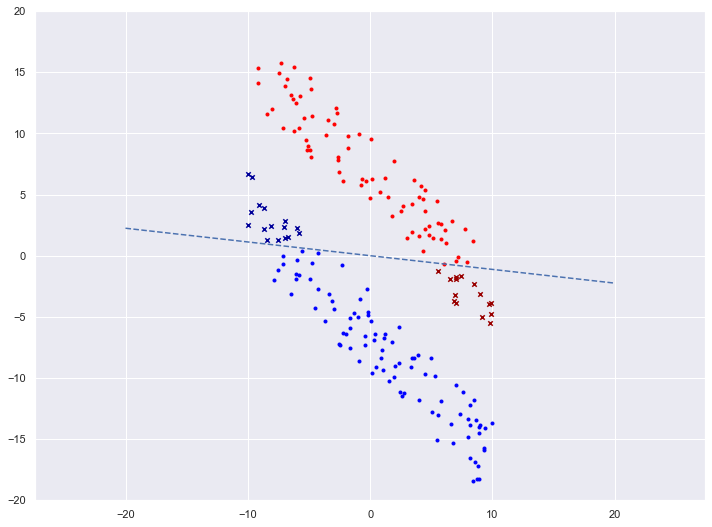

In [39]:
plot_data(lr_classifiers[0], small_data_X, small_data_Y)

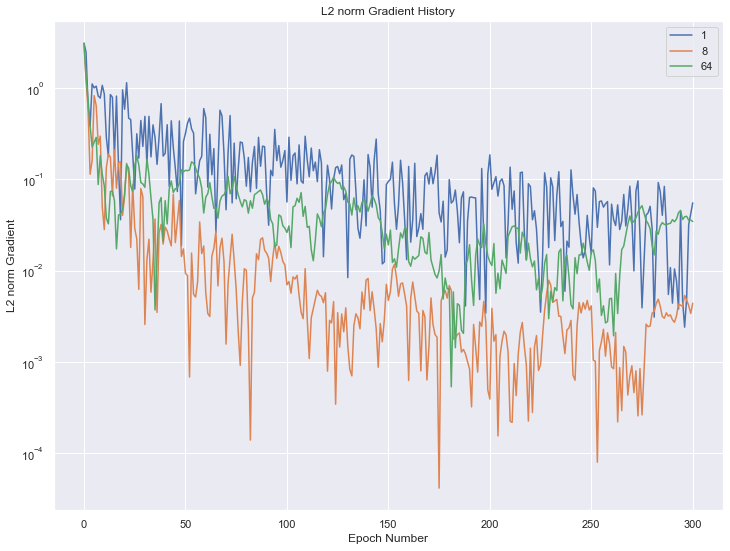

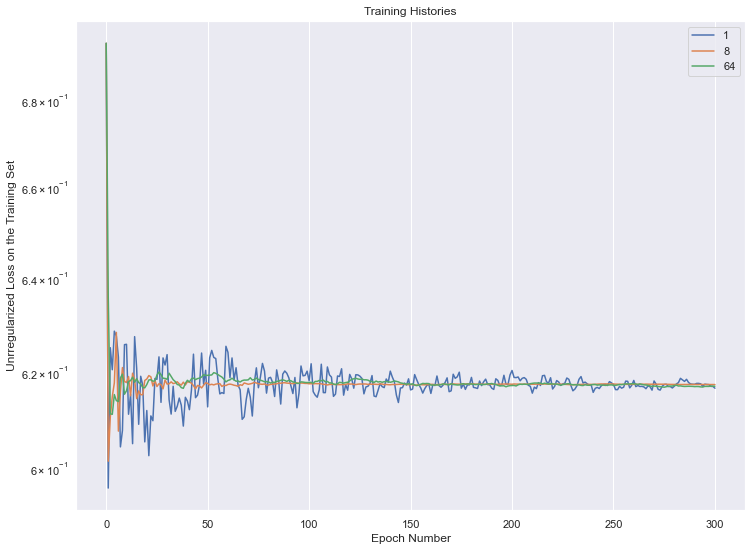

In [46]:
# Plot of L2 norm gradient history.
plt.figure(figsize=(12,9))
plt.yscale('log')

plt.ylabel('L2 norm Gradient')
plt.xlabel('Epoch Number')
plt.title('L2 norm Gradient History')
for lr_classifier in lr_classifiers:
    plt.plot([epoch for epoch in 
            range(len(lr_classifier.l2_norm_gradient_history_))], 
            lr_classifier.l2_norm_gradient_history_,
            label=lr_classifier.mini_batch_size_)
plt.legend()

# Plot of training histories
plt.figure(figsize=(12,9))
plt.title('Training Histories')
plt.xlabel('Epoch Number')
plt.yscale('log')
plt.ylabel('Unrregularized Loss on the Training Set')
for lr_classifier in lr_classifiers:
    plt.plot([epoch for epoch in 
            range(len(lr_classifier.training_unregularized_loss_history_))],
            lr_classifier.training_unregularized_loss_history_,
            label=lr_classifier.mini_batch_size_)
plt.legend()

## Test: `pegasos` for Regularized Hinge Loss SVM ##
We can run with the initial $\eta = 0.1$ and the regularization parameter $\lambda = 100$ for $T = 300$. As $| M |$ becomes larger, the result should converge to that of the second checkpoint.

In [41]:
# Train Pegasos logistic regression classifier.
svm_classifier_obj = svm_classifier(small_data_X.shape[1])
pegasos(svm_classifier_obj, small_data_X, small_data_Y, None, None, 
        regularization=100, n_epochs=300, mini_batch_size=20)
print(svm_classifier_obj.weight_)

Epoch  50  is complete...
Epoch  100  is complete...
Epoch  150  is complete...
Epoch  200  is complete...
Epoch  250  is complete...
Epoch  300  is complete...
[-0.0043796 -0.0589139]


<a id='s3.5'></a>
# 3.5 Pegasos on Criteo CTR Prediction Data
Each function and class has been tested on a smaller dataset and passed, so the classifiers are ready for the real data. 

First, I'll try the regularized logistic regression classifier, `lr_classifier`, with $\lambda = 0.1$ (`regularization`) and $T = 100$ (`n_epochs`).

In [ ]:
# Train Pegasos logistic regression classifier.
lr_classifier = logistic_regression_classifier(X_train.shape[1])
pegasos(lr_classifier, 
        X_train.values, Y_train.values,
        X_test.values, Y_test.values, 
        regularization=0.1, n_epochs=100, mini_batch_size=64)
print(lr_classifier.weight_)

In [ ]:
# Plot validation histories.
plt.figure(figsize=(12,9))
plt.yscale('log')
plt.xlabel('Epoch Num')
plt.ylabel('Unrregularized Loss on the Validation Set')
plt.plot([epoch for epoch in 
        range(len(lr_classifier.validation_unregularized_loss_history_))], 
        lr_classifier.validation_unregularized_loss_history_, 
        label=lr_classifier.mini_batch_size_)
plt.legend()

Again using $\lambda = 0.1$ and $T = 100$, we'll run on the regularized hinge loss SVM.

In [ ]:
# Train Pegasos logistic regression classifier.
svm_classifier_obj = svm_classifier(training_data_X.shape[1])
pegasos(svm_classifier_obj, 
        X_train.values, Y_train.values, 
        X_test.values, Y_test.values,
        regularization=0.1, n_epochs=100, mini_batch_size=64)
print(svm_classifier_obj.weight_)

In [ ]:
# Plot validation histories.
plt.figure(figsize=(12,9))
plt.yscale('log')
plt.xlabel('Epoch Num')
plt.ylabel('Unrregularized Loss on the Validation Set')
plt.plot([epoch for epoch in 
        range(len(svm_classifier_obj.validation_unregularized_loss_history_))], 
        svm_classifier_obj.validation_unregularized_loss_history_, 
        label=lr_classifier.mini_batch_size_)
plt.legend()

<a id='sTODO'></a>
# TODO: #
- Find a setting of parameters $\lambda$ and $| M |$ that gives the best accuracy on the validation set.
  - What do you even mean by "best" here?
- Optimize the code to work on sparse data
- Improve the documentation of each class and function.
  - Consider adding docstrings and clarifying necessary comments